In [ ]:
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
%env PLATFORM_TOKEN=

In [2]:
import importlib
importlib.reload(capturing)

NameError: name 'capturing' is not defined

In [105]:
import sys
import json
import cv2
import torch
import imageio
import torchvision
import pytorch_lightning as pl
sys.path.append("..")

In [4]:
from parsing import parse_request_details, parse_train_details
from model import InfractionDetectionModel
from dataset import DemonstrationImageDataset
from constants import MODEL_BASE_DIR, PLATFORM_ENDPOINT, TOKEN, TRAINED_NAME
import capturing
import training
import inference
import connection

In [5]:
threads_dict = dict()
begin_positive = dict()
begin_negative = dict()

In [283]:
req = json.loads("""{
    "kvs_arn":"arn:aws:kinesisvideo:us-east-1:588475495754:stream/test-stream-2/1644346254536",
    "infraction_type_id": "3",
    "device_serial_number": "3",
    "output_url" : "http://172.31.22.1:5000/local_requests",
    "between_captures" : 1,
    "stream_delay" : 20,
    "num_captures" : 800
}""")

In [284]:
parsed_details = parse_request_details(req)
train_request = parse_train_details(req)
begin_positive[parsed_details.details_string] = False
begin_negative[parsed_details.details_string] = False

In [11]:
import boto3
import os
kvs_arn = "arn:aws:kinesisvideo:us-east-1:588475495754:stream/test-stream-2/1644346254536"
from constants import AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, REGION

kvs_client = boto3.client(
    'kinesisvideo',
    aws_access_key_id= AWS_ACCESS_KEY_ID,
    aws_secret_access_key= AWS_SECRET_ACCESS_KEY,
    region_name= REGION
    )
kvs_endpoint = kvs_client.get_data_endpoint(
    StreamARN=kvs_arn,
    APIName="GET_HLS_STREAMING_SESSION_URL"
)

In [136]:
url = connection.initialize_new_stream(parsed_details.kvs_arn)

In [160]:
capturing.collection_management(parsed_details, train_request, begin_positive, begin_negative, continue_number, wait_request=False)

400
Image collection complete


In [39]:
print(os.path.join(model_dir,"positive"))

tmp/capstone//3/3/positive


In [285]:
#lightning module
import pytorch_lightning as pl
import torchvision
import torch
from sklearn.metrics import precision_recall_fscore_support
from torchvision import transforms as tr

pipeline = tr.Compose(
             [tr.Grayscale(num_output_channels=3),
              tr.RandomRotation(degrees = 270),
              tr.RandomHorizontalFlip(),
              tr.RandomVerticalFlip(),
              tr.RandomPerspective(distortion_scale=0.3, p=0.5)])
pipeline2 = tr.Compose(
    [tr.Grayscale(num_output_channels=3)])


loss_func = torch.nn.BCELoss()
activation_func  = torch.nn.Sigmoid()

class InfractionDetectionModel2(pl.LightningModule):
    def __init__(self, train_dataset=None, val_dataset=None, model=None, col_fn=None, learning_rate=5e-5, num_loading_cpus=2, batch_size=1):
        super().__init__() 
        self.model =  model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.col_fn = col_fn
        self.learning_rate = learning_rate
        self.num_loading_cpus = num_loading_cpus
        self.batch_size = batch_size
    
    def forward(self,x):
        f = activation_func(self.model.forward(x))
        return f
    
    def training_step(self, batch, batch_idx):
        x = pipeline(batch['data'])
        x = batch['data']
        y = torch.unsqueeze(batch['labels'],0).float()
        y_hat = self.forward(x.float())

        print('y_hat ', y_hat, " y", y)
        loss = loss_func(y_hat,y)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x = pipeline2(batch['data'])
        y = torch.unsqueeze(batch['labels'],0).float()
        with torch.no_grad():
            y_hat = self.forward(x.float())
            loss = loss_func(y_hat,y)
            y = torch.round(y).tolist()[0]
            y_hat = torch.round(y_hat).tolist()[0]
            precision, recall, fscore, support = precision_recall_fscore_support(y, y_hat, average='micro')
            self.log("val_loss", loss)
            self.log("precision", precision)
            self.log("recall", recall)
            return {"val_loss" : loss, "precision" : precision, "recall" : recall}
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,batch_size=self.batch_size,collate_fn=self.col_fn)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,batch_size=self.batch_size,collate_fn=self.col_fn)     
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
def col_fn(batch):
    out = dict()
    out['data'] = torch.stack([x['data'] for x in batch[0]])
    out['labels'] = torch.stack([x['labels'] for x in batch[0]])
    return out

model_dir= f'{MODEL_BASE_DIR}/{parsed_details.details_string}'

dataset = DemonstrationImageDataset(
    img_dir_true = "/home/cameron/safety-vision-ml/notebooks/tmp/capstone/3/3/positive",
    img_dir_false ="/home/cameron/safety-vision-ml/notebooks/tmp/capstone/3/3/negative",
    )

train_set, val_set = torch.utils.data.random_split(
    dataset,
    [len(dataset)-train_request.eval_size, train_request.eval_size],
    )

model =  torchvision.models.mobilenet_v2(pretrained=True)
#model2 =  torchvision.models.mobilenet_v2(pretrained=True)
#print(model)
#print(model2)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features,out_features=1)
#model.fc = torch.nn.Linear(in_features=model.fc.in_features,out_features=1)
agh = InfractionDetectionModel2(train_set, val_set, model, col_fn) 
trainer = pl.Trainer(max_epochs=5)
print('begin training')
trainer.fit(agh)

In [339]:
trainer.validate()

/home/cameron/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /home/cameron/safety-vision-ml/notebooks/lightning_logs/version_15/checkpoints/epoch=4-step=799.ckpt
Loaded model weights from checkpoint at /home/cameron/safety-vision-ml/notebooks/lightning_logs/version_15/checkpoints/epoch=4-step=799.ckpt
/home/cameron/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'precision': 0.95, 'recall': 0.95, 'val_loss': 0.3707946538925171}
--------------------------------------------------------------------------------


[{'val_loss': 0.3707946538925171, 'precision': 0.95, 'recall': 0.95}]

In [14]:
model_path

'tmp/capstone//3/3/trained.ckpt'

In [162]:
import torch
import torchvision
M = torch.nn.Sigmoid()

In [382]:
with torch.no_grad():
    #Loading model and making binary classifier
    #model_init =  torchvision.models.resnet50(pretrained=False)
    #model_init.fc = torch.nn.Linear(in_features=model_init.fc.in_features,out_features=1)
    #model = InfractionDetectionModel.load_from_checkpoint(model_path,model=model_init)
    agh.eval()
    url = connection.initialize_new_stream(parsed_details.kvs_arn)
    cap = cv2.VideoCapture(url)
    ret, frame = cap.read()
    frame = cv2.resize(frame, (224,224)) 
    ft = torch.tensor(frame)
    ft = torch.transpose(ft,0,2)
    ft= ft.unsqueeze(0)
    ft = pipeline2(ft)
    out = agh.forward(ft.float())
    #out = M(out)

In [383]:
out

tensor([[0.3936]])

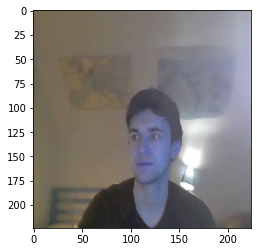

In [384]:
import matplotlib.pyplot as plt
plt.imshow(frame)

In [297]:
hm = pipeline(ft)

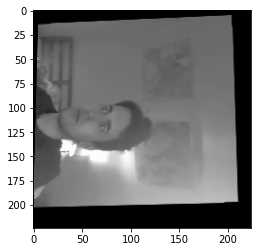

In [298]:
plt.imshow(torch.transpose(hm.squeeze(),0,2).numpy())

In [196]:
with torch.no_grad():
    #Loading model and making binary classifier
    #model_init =  torchvision.models.resnet50(pretrained=False)
    #model_init.fc = torch.nn.Linear(in_features=model_init.fc.in_features,out_features=1)
    #model = InfractionDetectionModel.load_from_checkpoint(model_path,model=model_init)
    #agh.eval()
    #url = connection.initialize_new_stream(parsed_details.kvs_arn)
    #cap = cv2.VideoCapture(url)
    #ret, frame = cap.read()
    #frame = cv2.resize(frame, (224,224)) 
    #cv2.imwrite("./test.png",frame)
    e = torch.transpose(torch.tensor(imageio.imread("./tmp/capstone/3/3/negative/0img0.png")),0,2).unsqueeze(0)
    #ft = torch.tensor(frame)
    #ft = torch.transpose(ft,0,2)
    #ft= ft.unsqueeze(0)
    out = agh.forward(e.float())

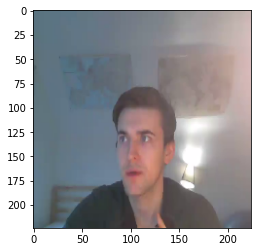

In [126]:
l = torch.transpose(torch.tensor(imageio.imread("./test.png")),0,2).unsqueeze(0)
plt.imshow(torch.transpose(l.squeeze(),0,2).numpy())

In [23]:
url = connection.initialize_new_stream(parsed_details.kvs_arn)
threads_dict[parsed_details.details_string] = True
inference.run_inference(
    parsed_details,
    train_request,
    url,
    model_path,
    threads_dict
)

NameError: name 'model_path' is not defined